# Dataset

In [1]:
import os
import numpy as np
import pandas as pd
from skimage import transform
import librosa

import torch
from torch.utils.data import Dataset

# # local functions
# from dataset.utils import *

In [2]:
class DepressionDataset(Dataset):
    '''create a training, develop, or test dataset
       and load the participant features if it's called
    '''

    def __init__(self,
                 root_dir,
                 mode,
                 transform=None):
        super(DepressionDataset, self).__init__()

        # only train, develop, test dataset allow
        assert mode in ["train", "validation", "test"], \
            "Argument --mode could only be ['train', 'validation', 'test']"

        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform
        self.train_data_path = os.path.join(self.root_dir, 'train_split_Depression_AVEC2017.csv')
        self.valid_data_path = os.path.join(self.root_dir, 'dev_split_Depression_AVEC2017.csv')
        self.test_data_path = os.path.join(self.root_dir, 'full_test_split.csv')
        # load sent2vec model for converting text file to 2D array
#         self.sent2vec = SentenceTransformer('all-mpnet-base-v2')  # output dimension 768

        # load training data # 107 sessions
        if self.mode == "train":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.train_data_path))
            # store ground truth
            ####################################################################################################
            # self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.patientIDs = np.array([303, 321, 362, 363, 426])  # for debugging on my laptop
            ####################################################################################################
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load development data # 35 sessions
        if self.mode == "validation":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.valid_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load test data # 47 sessions
        if self.mode == "test":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.test_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            # subscores in test data are not provided, thus we initialize it with 0 to avoid error for DataLoader
            self.phq_subscores_gt = np.zeros((self.patientIDs.shape[0],  8))

            
    def pre_check(self, data):
        '''
        Basic cleaning process to make sure no missing value
        and that the sum of each PHQ subscore equals to PHQ score
        Argument:
            data: numpy array
        Return:
            data: numpy array with type "int"
        '''
        # make sure no NaN, Inf, -Inf
        if data.isin([np.nan, np.inf, -np.inf]).any(1).sum():
            print('Replacing NaN, Inf, or -Inf ...')
            data = data.replace([np.inf, -np.inf, np.nan], 0)  # .astype('int')
        else:
            data = data  # .astype('int')

        # compare the sum of each PHQ subscore to PHQ score
        unequal = data.iloc[:, 4:].sum(axis=1) != data.iloc[:, 2]
        if unequal.any() and self.mode != 'test':
            lines = np.where(unequal)
            raise ValueError(("The sum of each PHQ subscore at line {} "
                              "is unequal to the PHQ score").format(lines[0]))

        return data

    
    def __len__(self):
        return len(self.patientIDs)

    
    def __iter__(self):
        return iter(self.patientIDs)
    
    
    def __getitem__(self, idx):
        '''
        Essentional function for creating dataset in PyTorch, which will automatically be
        called in Dataloader and load all the extracted features of the patient in the Batch
        based on the index of self.patientIDs
        Argument:
            idx: int, index of the patient ID in self.patientIDs
        Return:
            session: dict, contains all the extracted features and ground truth of a patient/session
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # get the patient session path
        session_num = self.patientIDs[idx]
        session_path = os.path.join(self.root_dir, '{}_P'.format(session_num))

        # TODO: if other feature is needed, add more in the following part...

        # get audio feature path
        audio_path = os.path.join(session_path, '{}_AUDIO.wav'.format(session_num))
        
        # audio feature extration
        audio, self.audio_parameters = self.load_audio(audio_path)
        
        # summary
        session = {'patientID': session_num,
                   'session_path': session_path,
                   'audio': audio,
                   'phq_score_gt': self.phq_score_gt[idx],
                   'phq_binay_gt': self.phq_binay_gt[idx],
                   'phq_subscores_gt': self.phq_subscores_gt[idx],
                   'gender_gt': self.gender_gt[idx]}
        
#         # get all features path of the session
#         facial_landmarks_path = os.path.join(session_path, '{}_CLNF_features3D.txt'.format(session_num))
#         gaze_direction_path = os.path.join(session_path, '{}_CLNF_gaze.txt'.format(session_num))
#         audio_path = os.path.join(session_path, '{}_AUDIO.wav'.format(session_num))
#         text_path = os.path.join(session_path, '{}_TRANSCRIPT.csv'.format(session_num))
        
#         # facial feature
#         facial_landmarks = self.load_facial_landmarks(facial_landmarks_path)
#         # gaze direction feature
#         gaze_direction = pd.read_csv(gaze_direction_path).iloc[:, 4:].to_numpy()
#         # audion feature, but constrain the rows based to match the shape of landmarks/gaze_sample
#         audio, self.audio_parameters = self.load_audio(audio_path)
#         audio = audio[:facial_landmarks.shape[0]]
#         # text feature
#         self.text_feature = self.load_sent2vec(text_path, speaker='Participant')
#         sentence_embedding = self.text_feature['sentence_embeddings']

#         # summary
#         session = {'patientID': session_num,
#                    'session_path': session_path,
#                    'facial_landmarks': facial_landmarks,
#                    'gaze_direction': gaze_direction, 
#                    'audio': audio,
#                    'sentence_embeddings': sentence_embedding,
#                    'phq_score_gt': self.phq_score_gt[idx],
#                    'phq_binay_gt': self.phq_binay_gt[idx],
#                    'phq_subscores_gt': self.phq_subscores_gt[idx],
#                    'gender_gt': self.gender_gt[idx]}

        if self.transform:
            session = self.transform(session)

        return session
    
    def load_audio(self, audio_path, 
                   spectro_type='mel_spectrogram', 
                   frame_size = 2048,
                   hop_size = 533,
                   sample_rate = 16000,
                   num_mel_bands = 80,
                   preprocess=True):
        '''
        Standard method of loading audio and extracting audio features
        with Short-Time Fourier Transform by utilizing librosa library
        Arguments:
            audio_path: string, absolute path to audio file
            preprocess: boolean, whether normalize the data
        Return:
            audio_feature: 2D numpy.ndarray, extracted audio feature (spectra) in dB
        '''
        # only spectrogram and mel_spectrogram are allow
        assert spectro_type in ['spectrogram', 'mel_spectrogram'],\
            "Argument --spectro could only be ['spectrogram', 'mel_spectrogram']"
        
        # parameter setting for Short-Time Fourier Transform
        audio_parameters = {'spectro_type': spectro_type,
                            'sample_rate': sample_rate,
                            'frame_size': frame_size,
                            'hop_size': hop_size, 
                            'num_mel_bands': num_mel_bands}
        
        # load audio file with librosa
        sampled_values, sr = librosa.load(audio_path, sr=audio_parameters['sample_rate'])  
        ''' According to documnet sample rate is 16kHz
            sampled_values: audio sampled values of time series
            sr: sampling rate of audio
        '''
        
        # extracting features
        if spectro_type == 'spectrogram':
            # use Short-Time Fourier Transform, return complex-valued matrix STFT coefficients
            extracted_values = librosa.stft(sampled_values, 
                                            n_fft=audio_parameters['frame_size'], 
                                            hop_length=audio_parameters['hop_size'])
            # calculating the spectrogram
            extracted_values = np.abs(extracted_values) ** 2
            # print("Shape of the extracted features in dB: {}".format(extracted_values.shape))
            
        elif spectro_type == 'mel_spectrogram':
            # get the Mel filter banks
            self.filter_banks = librosa.filters.mel(n_fft=audio_parameters['frame_size'], 
                                                    sr=audio_parameters['sample_rate'], 
                                                    n_mels=audio_parameters['num_mel_bands'])
            # extract the mel spectrograom
            extracted_values = librosa.feature.melspectrogram(sampled_values, 
                                                              sr=audio_parameters['sample_rate'], 
                                                              n_fft=audio_parameters['frame_size'], 
                                                              hop_length=audio_parameters['hop_size'], 
                                                              n_mels=audio_parameters['num_mel_bands'])
            # print("Shape of the extracted_values in dB: {}".format(extracted_values.shape))
            
        else:
            raise ValueError("The given value of spectro_type is not supported\n"
                             "'spectro_type' could only be 'spectrogram' or 'mel_spectrogram'")
        
        # convert amplitude to DBs
        # transpose the result so that the rows corresponds to time and column to frequence
        audio_feature = np.transpose(librosa.power_to_db(extracted_values))
        # print("Shape of the final extracted audio feature (spectra) in dB: {}".format(audio_feature.shape))
        
        if preprocess:
            audio_feature = audio_minmax_scaler(audio_feature)
            
        return audio_feature, audio_parameters
    

class Padding(object):
    ''' pad zero to each feature matrix so that they all have the same size '''

    def __init__(self, audio_output_size=(58989, 80)):
        super(Padding, self).__init__()
        '''
        Each output size could be 'int' or 'tuple'. 
        Integer would be the number of desired rows
        and Tuple would be the desired 2D array size.

        Here is recommended to keep the number of columns 
        as they are and only set the number of rows with int

        To find the maximum length of rows, please use the 
        'find_max_length' function in utils to search through. 

        The value 386 are the maximum length in our case.
        '''
        assert isinstance(audio_output_size, (int, tuple))
        self.audio_output_size = audio_output_size

        
    def __call__(self, session):
        audio = session['audio']
        
        # audio padding along heigh dimension
        if isinstance(self.audio_output_size, int):
            h, w = audio.shape
            new_h = self.audio_output_size if h > self.audio_output_size else h
            padded_audio = np.zeros((self.audio_output_size, w))
            padded_audio[:new_h, :w] = audio[:new_h, :w]
        
        # audio padding along both heigh and width dimension
        else:
            h, w = audio.shape
            new_h = self.audio_output_size[0] if h > self.audio_output_size[0] else h
            new_w = self.audio_output_size[1] if w > self.audio_output_size[1] else w
            padded_audio = np.zeros(self.audio_output_size)
            padded_audio[:new_h, :new_w] = audio[:new_h, :new_w]

        # summary
        padded_session = {'patientID': session['patientID'],
                          'session_path': session['session_path'],
                          'audio': padded_audio,
                          'phq_score_gt': session['phq_score_gt'],
                          'phq_binay_gt': session['phq_binay_gt'],
                          'phq_subscores_gt': session['phq_subscores_gt'],
                          'gender_gt': session['gender_gt']}

        return padded_session

    
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Arguments:
        output_size:(tuple or int),  Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size=(256, 256)):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, session):
        audio = session['audio']

        h, w = audio.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        rescaled_audio = transform.resize(audio, (new_h, new_w))

        # summary
        rescaled_session = {'patientID': session['patientID'],
                            'session_path': session['session_path'],
                            'audio': rescaled_audio,
                            'phq_score_gt': session['phq_score_gt'],
                            'phq_binay_gt': session['phq_binay_gt'],
                            'phq_subscores_gt': session['phq_subscores_gt'],
                            'gender_gt': session['gender_gt']}

        return rescaled_session


class RandomCrop(object):
    """Crop randomly the image in a sample.
    Arguments:
        output_size:(tuple or int), Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size=(224, 224)):
        assert isinstance(output_size, (int, tuple))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, session):
        audio = session['audio']

        h, w = sentence_embeddings.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        cropped_audio = audio[top:top + new_h, left:left + new_w]

        # summary
        cropped_session = {'patientID': session['patientID'],
                           'session_path': session['session_path'],
                           'audio': cropped_audio,
                           'phq_score_gt': session['phq_score_gt'],
                           'phq_binay_gt': session['phq_binay_gt'],
                           'phq_subscores_gt': session['phq_subscores_gt'],
                           'gender_gt': session['gender_gt']}

        return cropped_session


class ToTensor(object):
    """Convert ndarrays in sample to Tensors or np.int to torch.tensor."""

    def __call__(self, session):
        converted_session = {'patientID': session['patientID'],
                             'session_path': session['session_path'],
                             'audio': torch.from_numpy(session['audio']).type(torch.FloatTensor),
                             'phq_score_gt': torch.tensor(session['phq_score_gt']).type(torch.FloatTensor),
                             'phq_binay_gt': torch.tensor(session['phq_binay_gt']).type(torch.FloatTensor),
                             'phq_subscores_gt': torch.from_numpy(session['phq_subscores_gt']).type(torch.FloatTensor),
                             'gender_gt': torch.tensor(session['gender_gt']).type(torch.FloatTensor)}

        return converted_session

## dataset/utils

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, transform
from mpl_toolkits.mplot3d import Axes3D


In [4]:
def minmax_scaler(data):
    '''recale the data, which is a 2D matrix, to 0-1 at each row'''
    return (data - data.min(axis=1)[:, np.newaxis]) / (data.max(axis=1) - data.min(axis=1))[:, np.newaxis]

def audio_minmax_scaler(data):
    '''recale audio data based on chosen min max value. 
    There will have 'NaN' problem if we rescale the audio data based on each line as 'minmax_scaler' above 
    does since some certain lines contain only same value such as -60 dB, which means almost silence. Thus 
    we create a new 'audio_minmax_scaler' function to rescale the data. 
    
    Most of the data is range between -60 ~ 20.
    '''
    data_min = -60
    data_max = 20
    return (data - data_min) / (data_max - data_min)

def show_spectrogram(audio_feature, audio_parameters, y_axis="log"):
    """Show log-spectrogram for a batch of samples.
    Arguments:
        audio_feature: 2D numpy.ndarray, extracted audio feature (spectra) in dB
        audio_parameters: dict, all parameters setting of STFT 
                          we used for feature extraction
        y_axis: certain string, scale of the y axis. could be 'linear' or 'log'
    Return:
        plot the spectrogram
    """

    # transpose, so the column corresponds to time series
    audio_feature = np.transpose(audio_feature)

    plt.figure(figsize=(25, 10))
    im = librosa.display.specshow(audio_feature, 
                                  sr=audio_parameters['sample_rate'], 
                                  hop_length=audio_parameters['hop_size'], 
                                  x_axis="time", 
                                  y_axis=y_axis)
    plt.colorbar(format="%+2.f dB")
    return im


def show_mel_filter_banks(filter_banks, audio_parameters):
    """Show Mel filter bank for a batch of samples.
    Arguments:
        filter_banks: 2D numpy.ndarray, please use self.filter_banks to get the value, 
                      but make sure load_audio(spectro_type='mel_spectrogram') is called
        audio_parameters: dict, all parameters setting of STFT 
                                we used for feature extraction
    Return:
        visualize the mel filter banks
    """
    plt.figure(figsize=(25, 10))
    im = librosa.display.specshow(filter_banks,
                                  sr=audio_parameters['sample_rate'], 
                                  x_axis="linear")
    plt.colorbar(format="%+2.f")
    return im


def find_max_length(root_dir):
    '''find out the maximum lenghth of each features among all patients'''

    # initialize each value
    max_length = {'landmarks': 0,
                  'gaze_samples': 0,
                  'sentences': 0}

    for name in os.listdir(root_dir):
        name_path = os.path.join(root_dir, name)
        if os.path.isdir(name_path) and name.endswith('_P'):
            session = name.split('_')[0]
            print('searching through patient {} ...'.format(session))

            facial_landmarks_path = os.path.join(name_path, '{}_CLNF_features3D.txt'.format(session))
            gaze_direction_path = os.path.join(name_path, '{}_CLNF_gaze.txt'.format(session))
            text_path = os.path.join(name_path, '{}_TRANSCRIPT.csv'.format(session))

            facial_landmarks = pd.read_csv(facial_landmarks_path)
            if len(facial_landmarks) > max_length['landmarks']:
                max_length['landmarks'] = len(facial_landmarks)

            gaze_direction = pd.read_csv(gaze_direction_path)
            if len(gaze_direction) > max_length['gaze_samples']:
                max_length['gaze_samples'] = len(gaze_direction)

            sentences = load_text_file(text_path, speaker='Participant')
            if len(sentences) > max_length['sentences']:
                max_length['sentences'] = len(sentences)

    if max_length['gaze_samples'] != max_length['landmarks']:
        max_length['gaze_samples'] = max_length['landmarks']

    return max_length


In [5]:
###############
# test the code
###############


if __name__ == '__main__':
    import sys
    from torch.utils.data import DataLoader
    from torchvision import transforms

    # sys.path.append('C:/Users/denni/Documents/KIT Studium/Bachelorarbeit')
    root_dir = 'C:/Users/denni/Documents/KIT Studium/Bachelorarbeit'

    # test 3: try to load the dataset with DataLoader
    transformed_dataset = DepressionDataset(os.path.join(root_dir, 'DAIC-WOZ Dataset'), 'train', 
                                            transform=transforms.Compose([Padding((58960, 80)), ToTensor()]))

    # create dataloader
    dataloader = DataLoader(transformed_dataset,
                            batch_size=2,
                            shuffle=False,
                            num_workers=0)
    # iterate through batches
    for i_batch, sample_batched in enumerate(dataloader):
        print('Batch number: ', i_batch, ', audio: ', sample_batched['audio'].size())
        print('=================================')
        if i_batch == 1:
            test_batch = sample_batched


Batch number:  0 , audio:  torch.Size([2, 58960, 80])
Batch number:  1 , audio:  torch.Size([2, 58960, 80])
Batch number:  2 , audio:  torch.Size([1, 58960, 80])


In [6]:
audio_feature = transformed_dataset[0]['audio']
print(audio_feature.shape)

torch.Size([58960, 80])


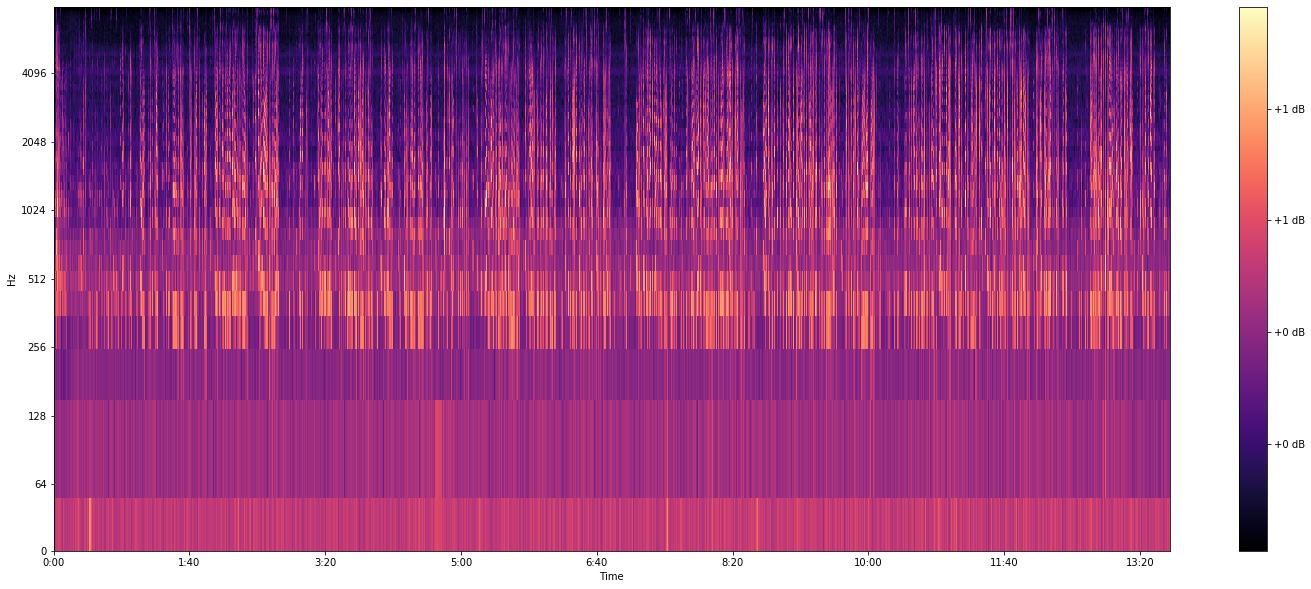

In [19]:
show_spectrogram(transformed_dataset[0]['audio'].numpy()[:24673], transformed_dataset.audio_parameters)

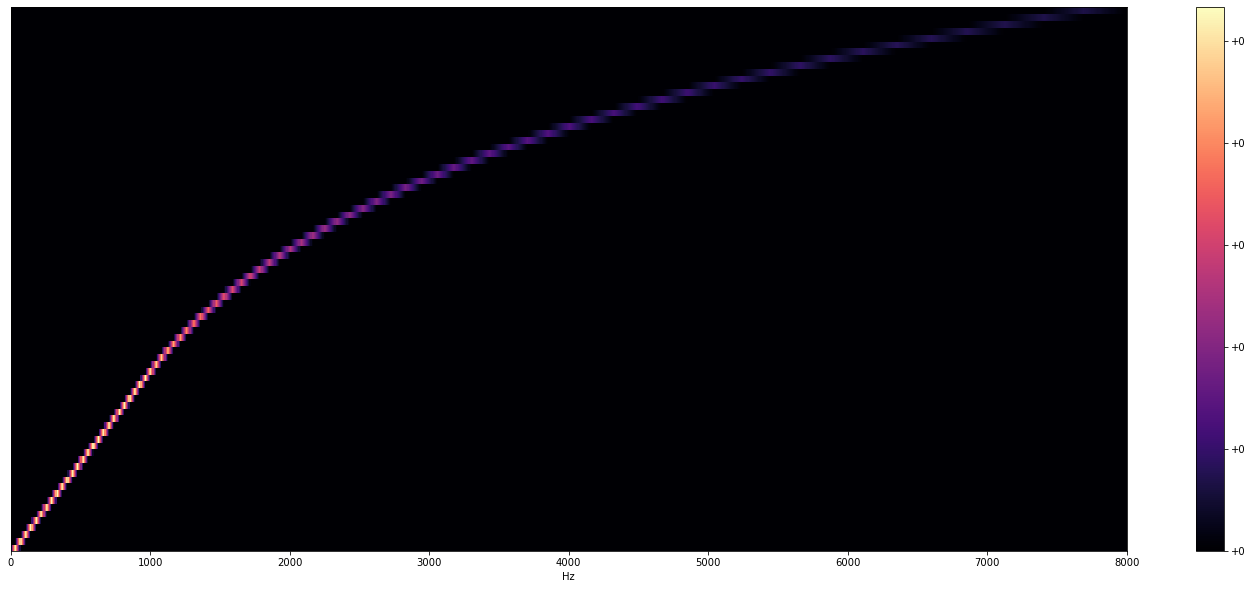

In [18]:
show_mel_filter_banks(transformed_dataset.filter_banks, transformed_dataset.audio_parameters)

# model: Video-Swin-Transformer

In [2]:
import torch
import torch.nn as nn
from video_swin_transformer import SwinTransformer3D

In [9]:
'''
initialize a SwinTransformer3D model
'''
model = SwinTransformer3D()

model = SwinTransformer3D(patch_size=(4,4,4),
                          in_chans=1,
                          embed_dim=96,
                          depths=[2, 2, 6, 2],
                          num_heads=[3, 6, 12, 24],
                          window_size=(2,7,7),
                          drop_rate=0.,
                          attn_drop_rate=0.,
                          drop_path_rate=0.2,
                          patch_norm=True)
print(model)

SwinTransformer3D(
  (patch_embed): PatchEmbed3D(
    (proj): Conv3d(1, 96, kernel_size=(4, 4, 4), stride=(4, 4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock3D(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention3D(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (fc2): Line

#### test the Vision-Transformer-Model with randon matrix

In [167]:
dummy_x = torch.rand(1, 3, 32, 224, 224)
logits = model(dummy_x)
print(logits.shape)

torch.Size([1, 768, 16, 7, 7])


In [170]:
dummy_x = torch.rand(2, 1, 32, 224, 224)
logits = model(dummy_x)
print(logits.shape)

torch.Size([2, 768, 16, 7, 7])


#### to get the final output feature

In [176]:
feature = logits.mean(dim=[2,3,4])
print(feature.shape)

torch.Size([2, 768])


In [178]:
# Optional ~

# project
batch_size, hidden_dim = feature.shape
feat_dim = 512
proj = nn.Parameter(torch.randn(hidden_dim, feat_dim))

# final output
output = feature @ proj # [batch_size, feat_dim]
print(output.shape)

torch.Size([2, 512])


### Start testing with our audio data

In [9]:
test_batch['audio'].shape

torch.Size([2, 58960, 80])

In [10]:
# reshape the matrix to match the requirement of input dimension

input_batch = test_batch['audio'].view(2, 1, -1, 80, 80)
input_batch.shape  # should match (B, c, D, H, W): batch_size, channels, Temperal_size, height, width

torch.Size([2, 1, 737, 80, 80])

In [11]:
result_feature = model(input_batch)
print(result_feature.shape)
feature = result_feature.mean(dim=[2,3,4])
print(feature.shape)

torch.Size([2, 768, 185, 3, 3])
torch.Size([2, 768])


In [10]:
# with different view shape

test_a = test_batch['audio'].view(2, 1, -1, 80*11, 80)[0].view(1, 1, -1, 80*11, 80)
test_a.shape

torch.Size([1, 1, 67, 880, 80])

In [11]:
model(test_a).shape

torch.Size([1, 768, 17, 28, 3])

#### laod pretrained model and tested with smaller input matrix " test_a "

In [12]:
checkpoint = torch.load('swin_tiny_patch4_window7_224.pth')

model_dict = model.state_dict()
# 1. filter out unnecessary keys
checkpoint_model = {k: v for k, v in checkpoint.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(checkpoint_model)
# 3. load the new state dict
model.load_state_dict(model_dict)

<All keys matched successfully>

In [13]:
result_feature = model(test_a)
print(result_feature.shape)
feature = result_feature.mean(dim=[2,3,4])
print(feature.shape)

torch.Size([1, 768, 17, 28, 3])
torch.Size([1, 768])


# nn.CrossEntropyLoss()

The class logits should be in dim1 in your use case, so you could permute your output as:

You can compute multiple cross-entropy losses but you'll need to do your own reduction. Since **cross-entropy loss assumes the feature dim is always the second dimension of the features tensor (logits should be in dim-1)** you will also need to permute it first.
```
loss_function = torch.nn.CrossEntropyLoss(reduction='none')
loss = loss_function(features.permute(0,2,1), targets).mean(dim=1)
```
which will result in a loss tensor with no_of_batches entries.


**add weights:**
if your loss function uses reduction='mean'(by default), the loss will be normalized by the sum of the corresponding weights for each element. If you are using reduction='none', you would have to take care of the normalization yourself.
Here is a small example:
```
x = torch.randn(10, 5)
target = torch.randint(0, 5, (10,))

weights = torch.tensor([1., 2., 3., 4., 5.])
criterion_weighted = nn.CrossEntropyLoss(weight=weights)
loss_weighted = criterion_weighted(x, target)

criterion_weighted_manual = nn.CrossEntropyLoss(weight=weights, reduction='none')
loss_weighted_manual = criterion_weighted_manual(x, target)
loss_weighted_manual = loss_weighted_manual.sum() / weights[target].sum()

print(loss_weighted == loss_weighted_manual)
```

In [66]:
# weights = torch.tensor([1., 2., 3., 4., 5.])  # maybe create weights for imbalance dataset
loss = nn.CrossEntropyLoss()
input = torch.randn(2, 5, 3, requires_grad=True)
target = torch.empty(2, 3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [56]:
torch.randn(3, 5, requires_grad=True)

tensor([[-0.7505, -0.7273, -0.8471, -1.6985,  0.2920],
        [ 0.2367,  0.3589, -3.1838, -0.4661, -0.0119],
        [-0.6663, -0.1088, -0.6465, -0.6523,  0.9648]], requires_grad=True)

In [67]:
a = torch.empty(2, 5, dtype=torch.long).random_(10)
a

tensor([[6, 2, 0, 0, 0],
        [6, 6, 4, 4, 1]])

In [89]:
probs = list([torch.randn(2, 4, requires_grad=True) for i in range(8)])
probs

[tensor([[-0.5576, -0.0900, -0.6617, -0.2937],
         [ 0.0611, -1.5109,  1.1828,  0.0899]], requires_grad=True),
 tensor([[ 1.6676,  0.7124, -0.3461, -0.0813],
         [ 0.5298,  1.2275, -0.2331, -0.9071]], requires_grad=True),
 tensor([[ 0.9260, -1.2116,  2.2487, -0.2808],
         [ 0.9137, -0.0300, -1.3763, -0.9151]], requires_grad=True),
 tensor([[ 0.5018, -1.3562,  0.1535, -0.0998],
         [-1.3743, -0.1121, -0.2551,  0.4811]], requires_grad=True),
 tensor([[-0.2230,  0.2694,  1.3649, -0.1668],
         [-1.2316,  0.8860,  0.3412, -2.6824]], requires_grad=True),
 tensor([[ 0.3305, -2.6648,  1.3529,  0.3278],
         [-0.0496,  0.8581, -0.4668, -0.3255]], requires_grad=True),
 tensor([[ 0.4497,  0.4990, -1.1866,  0.5218],
         [-0.4395, -0.2036, -0.3891, -0.7119]], requires_grad=True),
 tensor([[-0.7871,  0.5399,  0.0611,  1.9666],
         [ 0.0858,  0.3797,  0.2046,  1.0463]], requires_grad=True)]

In [91]:
gt = torch.empty(2, 8, dtype=torch.long).random_(4)
gt.shape

torch.Size([2, 8])

In [90]:
# method 1: stack all together and calculate the loss together

input_probs = torch.stack([prob for prob in probs], dim=1)
input_probs.shape

torch.Size([2, 8, 4])

In [92]:
output = loss(input_probs.permute(0,2,1).contiguous(), gt)
output.backward()

print(output)

tensor(1.8924, grad_fn=<NllLoss2DBackward0>)


In [93]:
# method 2: calculate the loss together and sum them up

total_loss = sum([loss(probs[i], gt[:, i]) for i in range(len(probs))])
print(total_loss)

tensor(15.1393, grad_fn=<AddBackward0>)


In [95]:
# the total loss should still be normalize by the number of the probs
# with this the total loss will be the same as method one

print(total_loss/8)

tensor(1.8924, grad_fn=<DivBackward0>)


# Debug SAM and Smooth Cross Entropy

In [1]:
import torch
import torch.nn as nn

from vit import ViT
from evaluator import Evaluator

from sam import SAM
from smooth_cross_entropy import smooth_crossentropy
from bypass_bn import enable_running_stats, disable_running_stats

### test with PHQ final score classification

In [2]:
# model init

vit_model = ViT(image_size=224,
                patch_size=8,
                num_classes=512,
                channels=1,
                dim=256,
                mlp_dim=512,
                depth=6,
                heads=8,
                dropout=0)

evaluator = Evaluator(feature_dim=512, 
                      output_dim=25, 
                      num_subscores=1)

In [ ]:
# # weights = torch.tensor([1, 1.558, 3.987, 6.442])  # .type(torch.FloatTensor).to(args.device)  # [1, 1.558, 4.5, 8.5]
# criterion = nn.CrossEntropyLoss()  # weight=weights
# optimizer = torch.optim.Adam([*vit_model.parameters()] + [*evaluator.parameters()],
#                              lr=1e-3,
#                              betas=(0.9, 0.999),
#                              weight_decay=1e-4)

In [3]:
# adaptive: True if you want to use the Adaptive SAM (ASAM)
# rho: Rho parameter, SAM uses rho=0.05, while ASAM is set to rho=2.0

criterion = nn.CrossEntropyLoss()

base_optimizer = torch.optim.Adam
optimizer = SAM([*vit_model.parameters()] + [*evaluator.parameters()], base_optimizer, 
                rho=2, adaptive=True, lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer.base_optimizer,
                                            step_size=5,
                                            gamma=0.95)

In [4]:
# simulate the output of model
# PHQ score (in batch form, batch_size 2)

phq_prob = torch.randn(2, 25, requires_grad=True)  # softmax form of prediction of 2 different patients
phq_gt = torch.empty(2, dtype=torch.long).random_(25)

print(phq_prob.shape)
print(phq_gt.shape)

torch.Size([2, 25])
torch.Size([2])


In [10]:
# simulate the input data
img = torch.randn(2, 1, 224, 224, requires_grad=True)
img

tensor([[[[-0.1310, -1.2633,  0.7059,  ...,  0.3686,  0.0203, -0.0375],
          [-0.1175, -1.2313,  0.2745,  ...,  0.4869,  0.2856,  0.1122],
          [-0.3002,  1.0113,  1.2075,  ..., -1.3309, -1.9842, -0.5626],
          ...,
          [-1.1158,  1.1819,  0.8780,  ...,  1.7356, -2.1449, -0.2274],
          [-0.3337, -1.2851,  0.2570,  ..., -0.3468, -0.1090, -0.0880],
          [-0.7197,  0.1122, -1.0753,  ..., -0.0814, -1.2248,  0.7795]]],


        [[[ 2.1938, -1.6176,  0.2739,  ..., -1.8452, -0.8246,  0.3643],
          [-1.0735, -0.2412, -1.6619,  ...,  0.4158, -0.4148, -0.6957],
          [ 0.9939,  1.2642, -1.1842,  ...,  0.9578, -1.7012,  0.5436],
          ...,
          [-0.0983, -0.1069, -0.1733,  ..., -1.5017, -0.0951, -1.3922],
          [-0.3066,  1.7677, -0.5713,  ..., -0.4543, -0.7442,  0.0639],
          [ 0.0469,  0.3269, -1.4343,  ...,  0.3546, -0.1505,  0.6737]]]],
       requires_grad=True)

In [6]:
# define model for starting prediction

def test_model(model_input, vit_model, evaluator):
    
    feature_output = vit_model(model_input.view(2, 1, 224, 224))
    probs_predict = evaluator(feature_output)
    
    return probs_predict[0]  # remember to convert to permute(0, 2, 1).contiguous() make sure dem-1 is softmax probabilities
    
# probs = evaluator(vit_model(img.view(2, 1, 224, 224)))

In [32]:
# print('lenght of probs: ', len(probs), ', shape of probs[0]: ', probs[0].shape)
# phq_probs = torch.stack([prob for prob in probs], dim=1)
# phq_probs.shape

lenght of probs:  1 , shape of probs[0]:  torch.Size([2, 25])


torch.Size([2, 1, 25])

In [7]:
models = [vit_model, evaluator]

# first forward-backward pass
for model in models:
    enable_running_stats(model)
loss = criterion(test_model(img, vit_model, evaluator), phq_gt)  # use this loss for any training statistics
loss.backward()
optimizer.first_step(zero_grad=True)

# second forward-backward pass
for model in models:
    disable_running_stats(model)
criterion(test_model(img, vit_model, evaluator), phq_gt).backward()  # make sure to do a full forward pass
optimizer.second_step(zero_grad=True)


### test with PHQ subscores classification

In [2]:
# model init

vit_model = ViT(image_size=224,
                patch_size=8,
                num_classes=512,
                channels=1,
                dim=256,
                mlp_dim=512,
                depth=6,
                heads=8,
                dropout=0)

evaluator = Evaluator(feature_dim=512, 
                      output_dim=4, 
                      num_subscores=8)

In [3]:
# adaptive: True if you want to use the Adaptive SAM (ASAM)
# rho: Rho parameter, SAM uses rho=0.05, while ASAM is set to rho=2.0

criterion = nn.CrossEntropyLoss()

base_optimizer = torch.optim.Adam
optimizer = SAM([*vit_model.parameters()] + [*evaluator.parameters()], base_optimizer, 
                rho=2, adaptive=True, lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer.base_optimizer,
                                            step_size=5,
                                            gamma=0.95)

In [4]:
# create ground truth: batch=2, num_subscore=8 
phq_sub_gt = torch.empty(2, 8, dtype=torch.long).random_(4)

# create input image
img = torch.randn(2, 1, 224, 224, requires_grad=True)
img.shape

torch.Size([2, 1, 224, 224])

In [29]:
def whole_model(model_input, vit, evaluator):
    
    feature_output = vit(model_input.view(2, 1, 224, 224))
    probs = evaluator(feature_output)
    pred_prob = torch.stack([prob for prob in probs], dim=1)
    
    return pred_prob.permute(0, 2, 1).contiguous()  # make sure dem-1 is softmax probabilities

In [6]:
def whole_model(model_input):
    
    feature_output = vit_model(model_input.view(2, 1, 224, 224))
    probs = evaluator(feature_output)
    pred_prob = torch.stack([prob for prob in probs], dim=1)
    
    return pred_prob.permute(0, 2, 1).contiguous()  # make sure dem-1 is softmax probabilities

models = [vit_model, evaluator]

# first forward-backward pass
for model in models:
    enable_running_stats(model)
loss = criterion(whole_model(img), phq_sub_gt)  # use this loss for any training statistics
loss.backward()
optimizer.first_step(zero_grad=True)

# second forward-backward pass
for model in models:
    disable_running_stats(model)
criterion(whole_model(img), phq_sub_gt).backward()  # make sure to do a full forward pass
optimizer.second_step(zero_grad=True)

In [31]:
models = [vit_model, evaluator]

# first forward-backward pass
for model in models:
    enable_running_stats(model)
loss = criterion(whole_model(img, vit_model, evaluator), phq_sub_gt)  # use this loss for any training statistics
loss.backward()
optimizer.first_step(zero_grad=True)

# second forward-backward pass
for model in models:
    disable_running_stats(model)
criterion(whole_model(img, vit_model, evaluator), phq_sub_gt).backward()  # make sure to do a full forward pass
optimizer.second_step(zero_grad=True)

In [12]:
# PHQ subscore (in batch form, batch_size 2)

phq_sub_prob = torch.randn(2, 4, 8, requires_grad=True)  # softmax form of prediction of 2 different patients
phq_sub_gt = torch.empty(2, 8, dtype=torch.long).random_(4)

print(phq_sub_prob.shape)
print(phq_sub_gt.shape)

torch.Size([2, 4, 8])
torch.Size([2, 8])


## smooth_crossentropy

In [63]:
phq_prob = torch.randn(2, 25, requires_grad=True)  # softmax form of prediction of 2 different patients
phq_gt = torch.empty(2, dtype=torch.long).random_(25)

phq_sub_prob = torch.randn(2, 4, 8, requires_grad=True)  # softmax form of prediction of 2 different patients
phq_sub_gt = torch.empty(2, 8, dtype=torch.long).random_(4)


In [33]:
smooth_crossentropy(phq_prob, phq_gt)

tensor([3.9112, 2.2600], grad_fn=<SumBackward1>)

In [65]:
smooth_crossentropy(phq_sub_prob, phq_sub_gt).mean()

tensor(3.6044, grad_fn=<MeanBackward0>)

In [58]:
smooth_crossentropy(phq_sub_prob[:, :, i], phq_sub_gt[:, i]) for i in range(8)

[tensor([3.2226, 1.0394], grad_fn=<SumBackward1>),
 tensor([0.7981, 0.3276], grad_fn=<SumBackward1>),
 tensor([0.8274, 1.4762], grad_fn=<SumBackward1>),
 tensor([1.3610, 0.2850], grad_fn=<SumBackward1>),
 tensor([2.5182, 0.8310], grad_fn=<SumBackward1>),
 tensor([0.9896, 0.8131], grad_fn=<SumBackward1>),
 tensor([0.6210, 1.4662], grad_fn=<SumBackward1>),
 tensor([1.8269, 2.2105], grad_fn=<SumBackward1>)]

# WeightedRandomSampler

In [52]:
# example

import torch
import numpy as np
from torch.utils.data import WeightedRandomSampler, DataLoader

numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print('target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

# class_sample_count = np.array(
#     [len(np.where(target == t)[0]) for t in np.unique(target)])
class_sample_count = np.unique(target, return_counts=True)[1]

weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])
samples_weight = weight[target]

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1: {}/{}".format(i,
                                              len(np.where(target.numpy() == 0)[0]),
                                              len(np.where(target.numpy() == 1)[0])))

target train 0/1: 900/100
batch index 0, 0/1: 53/47
batch index 1, 0/1: 47/53
batch index 2, 0/1: 41/59
batch index 3, 0/1: 48/52
batch index 4, 0/1: 47/53
batch index 5, 0/1: 52/48
batch index 6, 0/1: 53/47
batch index 7, 0/1: 49/51
batch index 8, 0/1: 45/55
batch index 9, 0/1: 51/49


In [32]:
samples_weight

array([0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111111,
       0.00111111, 0.00111111, 0.00111111, 0.00111111, 0.00111

In [54]:
data = torch.FloatTensor(1908, data_dim)

phq_binary_gt = np.load('DAIC-WOZ Dataset/temp/phq_binary_gt.npy')
print('target train 0/1: {}/{}'.format(
    len(np.where(phq_binary_gt == 0)[0]), len(np.where(phq_binary_gt == 1)[0])))

class_sample_count = np.unique(phq_binary_gt, return_counts=True)[1]
print('class_sample_count: {}'.format(class_sample_count))

weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])
samples_weight = weight[phq_binary_gt]

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

phq_binary_gt = torch.from_numpy(phq_binary_gt).long()
train_dataset = torch.utils.data.TensorDataset(data, phq_binary_gt)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1: {}/{}".format(i,
                                              len(np.where(target.numpy() == 0)[0]),
                                              len(np.where(target.numpy() == 1)[0])))

target train 0/1: 1352/556
class_sample_count: [1352  556]
batch index 0, 0/1: 53/47
batch index 1, 0/1: 45/55
batch index 2, 0/1: 55/45
batch index 3, 0/1: 47/53
batch index 4, 0/1: 49/51
batch index 5, 0/1: 51/49
batch index 6, 0/1: 55/45
batch index 7, 0/1: 48/52
batch index 8, 0/1: 48/52
batch index 9, 0/1: 48/52
batch index 10, 0/1: 52/48
batch index 11, 0/1: 56/44
batch index 12, 0/1: 49/51
batch index 13, 0/1: 47/53
batch index 14, 0/1: 48/52
batch index 15, 0/1: 46/54
batch index 16, 0/1: 46/54
batch index 17, 0/1: 44/56
batch index 18, 0/1: 57/43
batch index 19, 0/1: 4/4


# Debug DepAudioNet

In [79]:
import math
import torch
import torch.nn as nn


def init_layer(layer):
    """Initialize a Linear or Convolutional layer.
    Ref: He, Kaiming, et al. "Delving deep into rectifiers: Surpassing
    human-level performance on imagenet classification." Proceedings of the
    IEEE international conference on computer vision. 2015.

    Input
        layer: torch.Tensor - The current layer of the neural network
    """

    if layer.weight.ndimension() == 4:
        (n_out, n_in, height, width) = layer.weight.size()
        n = n_in * height * width
    elif layer.weight.ndimension() == 3:
        (n_out, n_in, height) = layer.weight.size()
        n = n_in * height
    elif layer.weight.ndimension() == 2:
        (n_out, n) = layer.weight.size()

    std = math.sqrt(2. / n)
    scale = std * math.sqrt(3.)
    layer.weight.data.uniform_(-scale, scale)

    if layer.bias is not None:
        layer.bias.data.fill_(0.)


def init_lstm(layer):
    """
    Initialises the hidden layers in the LSTM - H0 and C0.

    Input
        layer: torch.Tensor - The LSTM layer
    """
    n_i1, n_i2 = layer.weight_ih_l0.size()
    n_i = n_i1 * n_i2

    std = math.sqrt(2. / n_i)
    scale = std * math.sqrt(3.)
    layer.weight_ih_l0.data.uniform_(-scale, scale)

    if layer.bias_ih_l0 is not None:
        layer.bias_ih_l0.data.fill_(0.)

    n_h1, n_h2 = layer.weight_hh_l0.size()
    n_h = n_h1 * n_h2

    std = math.sqrt(2. / n_h)
    scale = std * math.sqrt(3.)
    layer.weight_hh_l0.data.uniform_(-scale, scale)

    if layer.bias_hh_l0 is not None:
        layer.bias_hh_l0.data.fill_(0.)


def init_att_layer(layer):
    """
    Initilise the weights and bias of the attention layer to 1 and 0
    respectively. This is because the first iteration through the attention
    mechanism should weight each time step equally.

    Input
        layer: torch.Tensor - The current layer of the neural network
    """
    layer.weight.data.fill_(1.)

    if layer.bias is not None:
        layer.bias.data.fill_(0.)


def init_bn(bn):
    """
    Initialize a Batchnorm layer.

    Input
        bn: torch.Tensor - The batch normalisation layer
    """

    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


class ConvBlock1d(nn.Module):
    """
    Creates an instance of a 1D convolutional layer. This includes the
    convolutional filter but also the type of normalisation "batch" or
    "weight", the activation function, and initialises the weights.
    """
    def __init__(self, in_channels, out_channels, kernel, stride, pad,
                 normalisation, dil=1):
        super(ConvBlock1d, self).__init__()
        self.norm = normalisation
        self.conv1 = nn.Conv1d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel,
                               stride=stride,
                               padding=pad,
                               dilation=dil)
        if self.norm == 'bn':
            self.bn1 = nn.BatchNorm1d(out_channels)
        elif self.norm == 'wn':
            self.conv1 = nn.utils.weight_norm(self.conv1, name='weight')
        else:
            self.conv1 = self.conv1
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        """
        Initialises the weights of the current layer
        """
        init_layer(self.conv1)
        init_bn(self.bn1)

    def forward(self, input):
        """
        Passes the input through the convolutional filter

        Input
            input: torch.Tensor - The current input at this stage of the network
        """
        x = input
        if self.norm == 'bn':
            x = self.relu(self.bn1(self.conv1(x)))
        else:
            x = self.relu(self.conv1(x))

        return x


class ConvBlock2d(nn.Module):
    """
    Creates an instance of a 2D convolutional layer. This includes the
    convolutional filter but also the type of normalisation "batch" or
    "weight", the activation function, and initialises the weights.
    """
    def __init__(self, in_channels, out_channels, kernel, stride, pad,
                 normalisation, att=None):
        super(ConvBlock2d, self).__init__()
        self.norm = normalisation
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel,
                               stride=stride,
                               padding=pad)
        if self.norm == 'bn':
            self.bn1 = nn.BatchNorm2d(out_channels)
        elif self.norm == 'wn':
            self.conv1 = nn.utils.weight_norm(self.conv1, name='weight')
        else:
            self.conv1 = self.conv1
        self.att = att
        if not self.att:
            self.act = nn.ReLU()
        else:
            self.norm = None
            if self.att == 'softmax':
                self.act = nn.Softmax(dim=-1)
            elif self.att == 'global':
                self.act = None
            else:
                self.act = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        """
        Initialises the weights of the current layer
        """
        if self.att:
            init_att_layer(self.conv1)
        else:
            init_layer(self.conv1)
        init_bn(self.bn1)

    def forward(self, input):
        """
        Passes the input through the convolutional filter

        Input
            input: torch.Tensor - The current input at this stage of the network
        """
        x = input
        if self.att:
            x = self.conv1(x)
            if self.act():
                x = self.act(x)
        else:
            if self.norm == 'bn':
                x = self.act(self.bn1(self.conv1(x)))
            else:
                x = self.act(self.conv1(x))

        return x


class FullyConnected(nn.Module):
    """
    Creates an instance of a fully-connected layer. This includes the
    hidden layers but also the type of normalisation "batch" or
    "weight", the activation function, and initialises the weights.
    """
    def __init__(self, in_channels, out_channels, activation, normalisation,
                 att=None):
        super(FullyConnected, self).__init__()
        self.att = att
        self.norm = normalisation
        self.fc = nn.Linear(in_features=in_channels,
                            out_features=out_channels)
        if activation == 'sigmoid':
            self.act = nn.Sigmoid()
            self.norm = None
        elif activation == 'softmax':
            self.act = nn.Softmax(dim=-1)
            self.norm = None
        elif activation == 'global':
            self.act = None
            self.norm = None
        else:
            self.act = nn.ReLU()
            if self.norm == 'bn':
                self.bnf = nn.BatchNorm1d(out_channels)
            elif self.norm == 'wn':
                self.wnf = nn.utils.weight_norm(self.fc, name='weight')

        self.init_weights()

    def init_weights(self):
        """
        Initialises the weights of the current layer
        """
        if self.att:
            init_att_layer(self.fc)
        else:
            init_layer(self.fc)
        if self.norm == 'bn':
            init_bn(self.bnf)

    def forward(self, input):
        """
        Passes the input through the fully-connected layer

        Input
            input: torch.Tensor - The current input at this stage of the network
        """
        x = input
        if self.norm is not None:
            if self.norm == 'bn':
                x = self.act(self.bnf(self.fc(x)))
            else:
                x = self.act(self.wnf(x))
        else:
            if self.att:
                if self.act:
                    x = self.act(self.fc(x))
                else:
                    x = self.fc(x)
            else:
                if self.act:
                    x = self.act(self.fc(x))
                else:
                    x = self.fc(x)        

        return x


def lstm_with_attention(net_params):
    if 'LSTM_1' in net_params:
        arguments = net_params['LSTM_1']
    else:
        arguments = net_params['GRU_1']
    if 'ATTENTION_1' in net_params and 'ATTENTION_Global' not in net_params:
        if arguments[-1]:
            return 'forward'
        else:
            return 'whole'
    if 'ATTENTION_1' in net_params and 'ATTENTION_Global' in net_params:
        if arguments[-1]:
            return 'forward'
        else:
            return 'whole'
    if 'ATTENTION_1' not in net_params and 'ATTENTION_Global' in net_params:
        if arguments[-1]:
            return 'forward_only'
        else:
            return 'forward_only'


def reshape_x(x):
    """
    Reshapes the input 'x' if there is a dimension of length 1

    Input:
        x: torch.Tensor - The input

    Output:
        x: torch.Tensor - Reshaped
    """
    dims = x.dim()
    if x.shape[1] == 1 and x.shape[2] == 1 and x.shape[3] == 1:
        x = torch.reshape(x, (x.shape[0], 1))
    elif dims == 4:
        first, second, third, fourth = x.shape
        if second == 1:
            x = torch.reshape(x, (first, third, fourth))
        elif third == 1:
            x = torch.reshape(x, (first, second, fourth))
        else:
            x = torch.reshape(x, (first, second, third))
    elif dims == 3:
        first, second, third = x.shape
        if second == 1:
            x = torch.reshape(x, (first, third))
        elif third == 1:
            x = torch.reshape(x, (first, second))

    return x


class CustomMel(nn.Module):
    def __init__(self, input_dim, output_dim, conv_hidden, lstm_hidden, num_layers, activation, norm, dropout):
        super(CustomMel, self).__init__()
        self.conv = ConvBlock1d(in_channels=input_dim,      # 80
                                out_channels=conv_hidden,   # 128
                                kernel=3,
                                stride=1,
                                pad=1,
                                normalisation='bn')         # ['bn', 'wn', else]
        self.pool = nn.MaxPool1d(kernel_size=3,
                                 stride=3,
                                 padding=0)
        self.drop = nn.Dropout(dropout)                     # 0.2
        self.lstm = nn.LSTM(input_size=conv_hidden,         # 128
                            hidden_size=lstm_hidden,        # 128
                            num_layers=num_layers,          # 2
                            batch_first=True,
                            bidirectional=False)
        self.fc = FullyConnected(in_channels=lstm_hidden,   # 128
                                 out_channels=output_dim,   # 2
                                 activation=activation,     # ['sigmoid', 'softmax', 'global', else]
                                 normalisation=norm)

    def forward(self, net_input):
        x = net_input
        batch, freq, width = x.shape
        x = self.conv(x)
        x = self.pool(x)
        x = self.drop(x)
        x = torch.transpose(x, 1, 2)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :].reshape(batch, -1))

        return x


class CustomRaw(nn.Module):
    def __init__(self, input_dim, output_dim, conv_hidden, lstm_hidden, num_layers, activation, dropout):
        super(CustomRaw).__init__()
        # x = [(in + (2*pad) - (kernel-1) - 1) / stride] + 1
        self.conv1 = ConvBlock1d(in_channels=input_dim,     # 1
                                 out_channels=conv_hidden,  # 128
                                 kernel=1024,               # 512
                                 stride=512,                # 512
                                 pad=0,
                                 dil=1,
                                 normalisation='bn')

        self.conv2 = ConvBlock1d(in_channels=conv_hidden,   # 128
                                 out_channels=conv_hidden,  # 128
                                 kernel=3,
                                 stride=1,
                                 pad=1,
                                 normalisation='bn')

        self.pool1 = nn.MaxPool1d(kernel_size=3,
                                  stride=3,
                                  padding=0)

        self.drop = nn.Dropout(dropout)

        self.lstm = nn.LSTM(input_size=conv_hidden,         # 128
                            hidden_size=lstm_hidden,        # 128
                            num_layers=num_layers,          # 2
                            batch_first=True,
                            bidirectional=False)

        self.fc = FullyConnected(in_channels=lstm_hidden,   # 128
                                 out_channels=output_dim,   # 2
                                 activation=activation,     # ['sigmoid', 'softmax', 'global', else]
                                 normalisation=None)

    def forward(self, net_input):
        x = net_input
        batch, freq, width = x.shape
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.drop(x)
        x = torch.transpose(x, 1, 2)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :].reshape(batch, -1))

        return x

In [80]:
audio_net = CustomMel(input_dim=80, 
                      output_dim=768, 
                      conv_hidden=256, 
                      lstm_hidden=512, 
                      num_layers=2, 
                      activation='relu',
                      norm = 'bn',
                      dropout=0.2)

In [81]:
img = torch.randn(5, 80, 1800)
# phq_gt = torch.empty(2, dtype=torch.long).random_(25)

In [82]:
result = audio_net(img)

In [83]:
result.shape

torch.Size([5, 768])

In [86]:
result

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.9506, 0.6226],
        [0.0000, 0.5860, 0.0000,  ..., 0.0180, 0.0000, 0.8483],
        [0.6862, 0.0000, 1.6277,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1792, 0.6214,  ..., 0.1073, 0.0000, 0.0000],
        [1.4006, 1.4385, 0.0000,  ..., 1.4268, 0.0000, 0.6294]],
       grad_fn=<ReluBackward0>)